# **Milestone 1: exploration phase**
### **1- Load dataset & filter** (restrict to orders of at least 5 items)

In [2]:
import pandas as pd
import os

os.chdir('/home/miguel/zrive-ds')

dataset_path = "data/groceries/sampled_box_builder_df.csv"
df = pd.read_csv(dataset_path)
raw_length = df.shape[0]
df = df[df.groupby('order_id')['outcome'].transform('sum') >= 5]
filtered_length = df.shape[0]
print(f'Number of rows reduced by {round(filtered_length/raw_length*100, 2)}%, from {raw_length} raw, to {filtered_length} filtered.')

Number of rows reduced by 75.12%, from 2880549 raw, to 2163953 filtered.


### **2- Categorical encoding & data processing**

In [3]:
# Handle time-related features
df['hour'] = pd.to_datetime(df['created_at']).dt.hour
df['day_of_week'] = pd.to_datetime(df['order_date']).dt.dayofweek # Already cardinally encoded
df_filtered = df.drop(columns=['created_at', 'order_date'])

# Frequency Encoding for 'product_type' and 'vendor'
for col in ['product_type', 'vendor']:
    freq_map = df_filtered[col].value_counts(normalize=True)  # Compute frequency
    df_filtered[col] = df_filtered[col].map(freq_map)

df_filtered.head()

,variant_id,product_type,order_id,user_id,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,hour,day_of_week
0,33826472919172,0.044619,2807985930372,3482464092292,3,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,16,0
1,33826472919172,0.044619,2808027644036,3466586718340,2,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,17,0
2,33826472919172,0.044619,2808099078276,3481384026244,4,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,20,0
3,33826472919172,0.044619,2808393957508,3291363377284,2,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,8,1
5,33826472919172,0.044619,2808434524292,3479090790532,3,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10,1


In first place, it is important to be aware of the fact that linear models do not handle raw datetime values well, and in their raw form, they do not provide useful numerical information. However, I considered that it would be interesting to keep some information from those features. There might be any correlation between the hour in which the push notification is sent and the outcome chance. Same for the week day: it may be more efficient to push users on Fridays than on Wednesdays.

Facing the categorical feature encoding, it is absolutely unefficient to perform one-hot encoding, as it leaves a dataframe with 349 columns (curse of dimensionality). Frecuency encoding is proposed over it.

Finally, I would like to highlight the possibility of performing Target Encoding (mean Outcome encoding), this can be useful if the information leakage is correctly avoided and will be tried later if possible.

### **3- Three-way split**
**We will do it trying to ensure Sequential Integrity (avoid information leakage through `user_order_seq`)**

In [4]:
from sklearn.model_selection import train_test_split

# Ensure sequential integrity
df_sorted = df_filtered.sort_values(by=['user_id', 'user_order_seq'])

def sequential_train_test_split(df, test_size=0.15, random_state=42):
    """
    df: pandas Data.Frame with a 'user_id' feature (needs to be sorted by that feature).
    test_size: float between 0 and 1 (predetermined to 0.15 in order to get a 70/15/15 split).
    random_state: an integer seed for the random split (predetermined to 42).

    Ensures that if an order with user_order_seq = n is in train, then all previous ones (1, ..., n-1) are also in
    train by splitting unique users into train & test.
    """
    
    unique_users = df['user_id'].unique()
    train_users, test_users = train_test_split(unique_users, test_size=test_size, random_state=random_state)

    # Keep all rows of a user in the assigned split
    df_train = df[df['user_id'].isin(train_users)]
    df_test = df[df['user_id'].isin(test_users)]

    return df_train, df_test

# Split into train, validation, and test sets -> 70/20/10
df_train, df_temp = sequential_train_test_split(df_sorted, 0.2)
df_val, df_test = sequential_train_test_split(df_temp, 0.1)

# Define target and features
X_train = df_train.drop(columns=['outcome'])  # Features
y_train = df_train['outcome']  # Target

X_val = df_val.drop(columns=['outcome'])  # Features
y_val = df_val['outcome']  # Target

X_test = df_test.drop(columns=['outcome'])  # Features
y_test = df_test['outcome']  # Target

Here, a new function is introduced in order to perform the 3-way split over unique users, instead of doing it over rows, with the aim of avoiding information leakage. I know that, in production, past order information will be available for clients who have already ordered, so the optimal way to split data may be to do it time-wise. That will be tried later. This approach might be good in order to predict the behaviour of new clients. (I leave here noted the posibility of implementing 2 models: one for users who are already clients, and another for new customers).

### **3- Definition of evaluation metrics**

We will be using ROC and Precision-Recall curves as main evaluation metrics for our models. It will be important to be aware of the fact that a diagonal line is the baseline for ROC curve: the expected result when predictions are randomly made. However, this is not always true for PR curve (it is not in our case), since there is a high imbalance within our target feature `outcome`.

Therefore, the baseline precision (the precision expected for random predictions) in our case will be computed as follows:

In [19]:
baseline_precision = df['outcome'].sum() / len(df)
print(f"Baseline Precision: {baseline_precision:.4f}")

Baseline Precision: 0.0145


### **4- Modeling for unique user split**
**First Model** (Logistic regression with L2 regularisation)

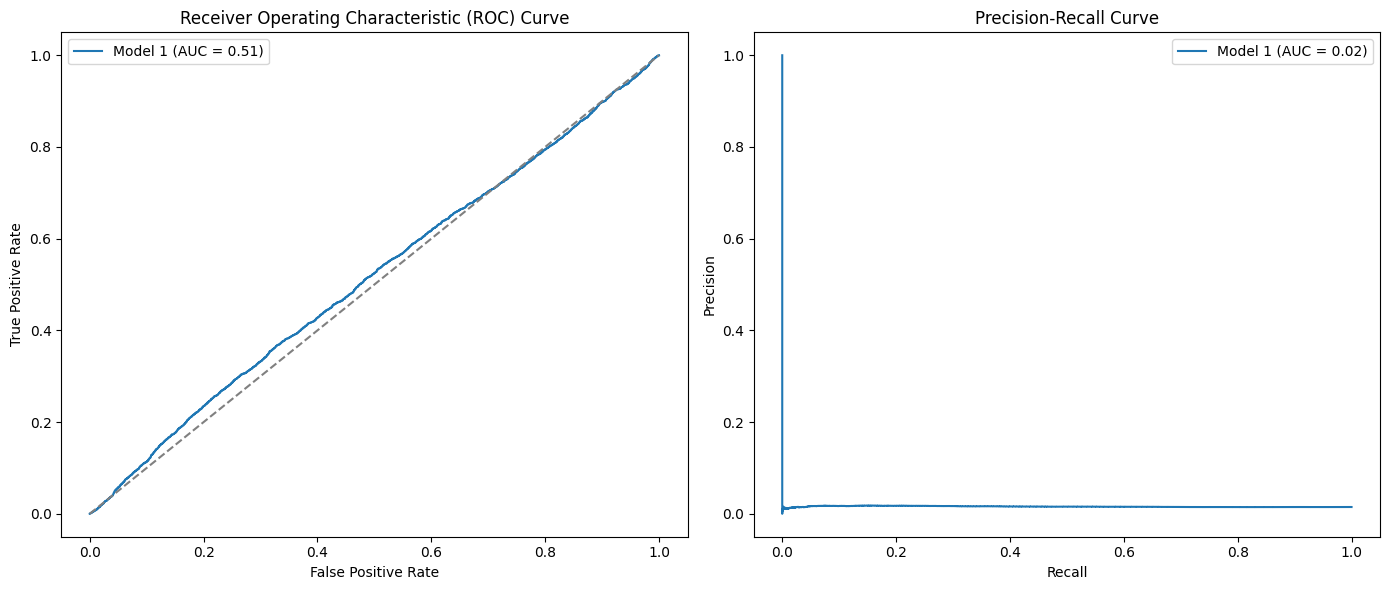

In [5]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(penalty='l2', max_iter=1000)
logistic_model.fit(X_train, y_train)

from src.module_3.metrics_fun import plot_roc_pr_curves
plot_roc_pr_curves(logistic_model, X_val, y_val)

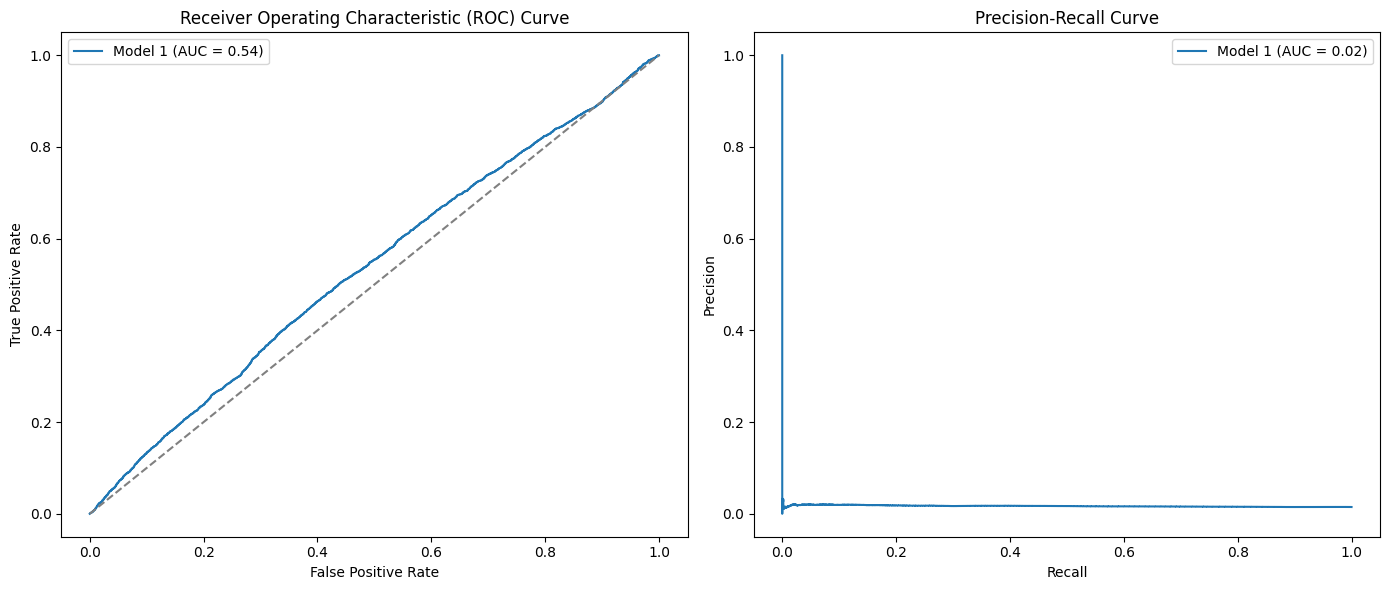

In [6]:
logistic_model_weighted = LogisticRegression(class_weight="balanced", max_iter=1000)
logistic_model_weighted.fit(X_train, y_train)

plot_roc_pr_curves(logistic_model_weighted, X_val, y_val)

**Second Model** (Ridge linear model)

/home/miguel/.cache/pypoetry/virtualenvs/zrive-ds-faYnIO2J-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.62149e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


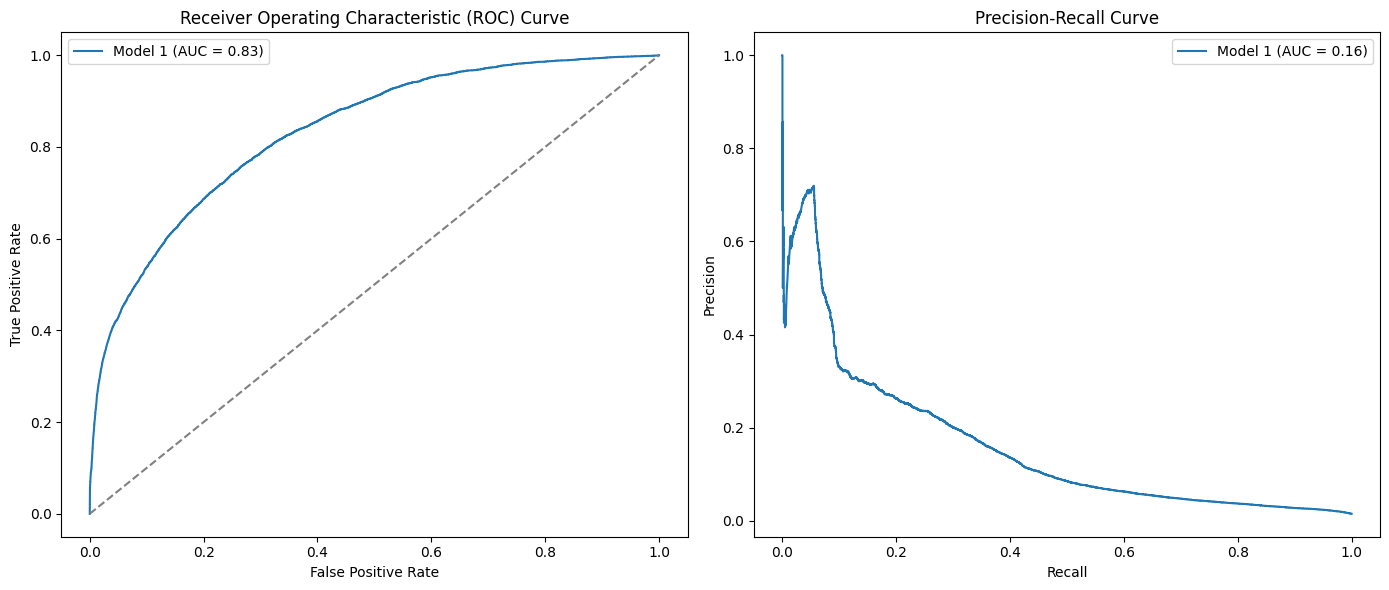

In [7]:
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier(alpha=1.0)
ridge_model.fit(X_train, y_train)

plot_roc_pr_curves(ridge_model, X_val, y_val)

/home/miguel/.cache/pypoetry/virtualenvs/zrive-ds-faYnIO2J-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.62641e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


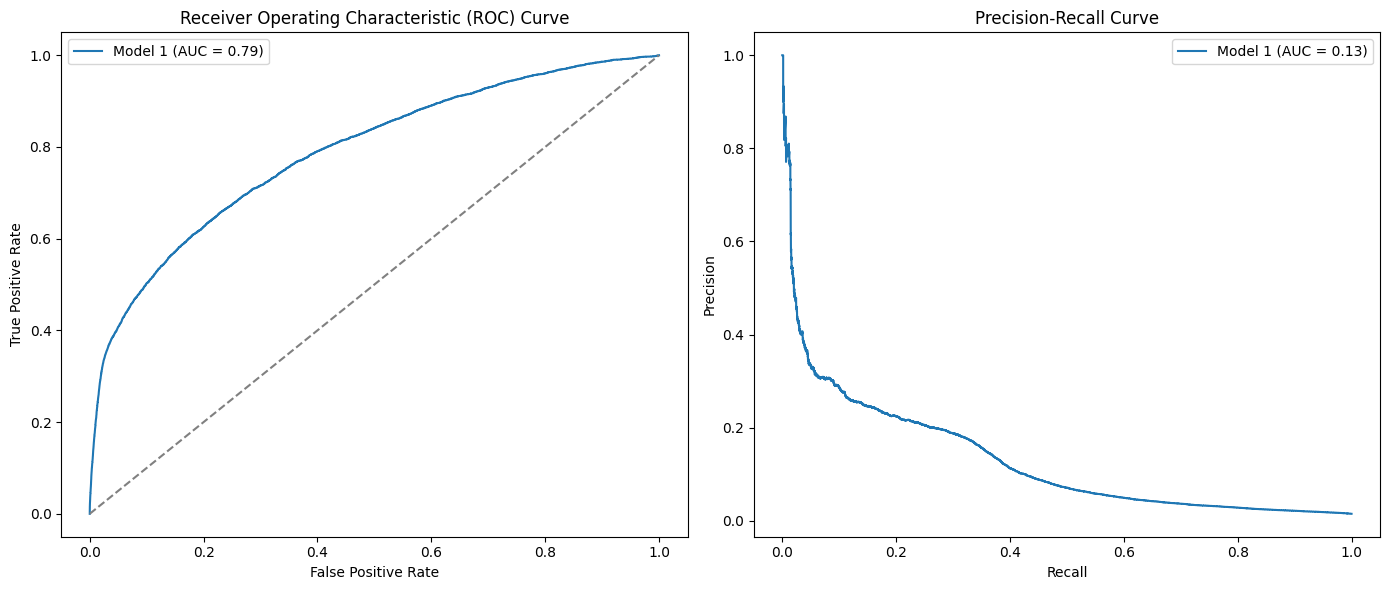

In [8]:
ridge_model_weighted = RidgeClassifier(class_weight="balanced", alpha=1.0)
ridge_model_weighted.fit(X_train, y_train)

plot_roc_pr_curves(ridge_model_weighted, X_val, y_val)

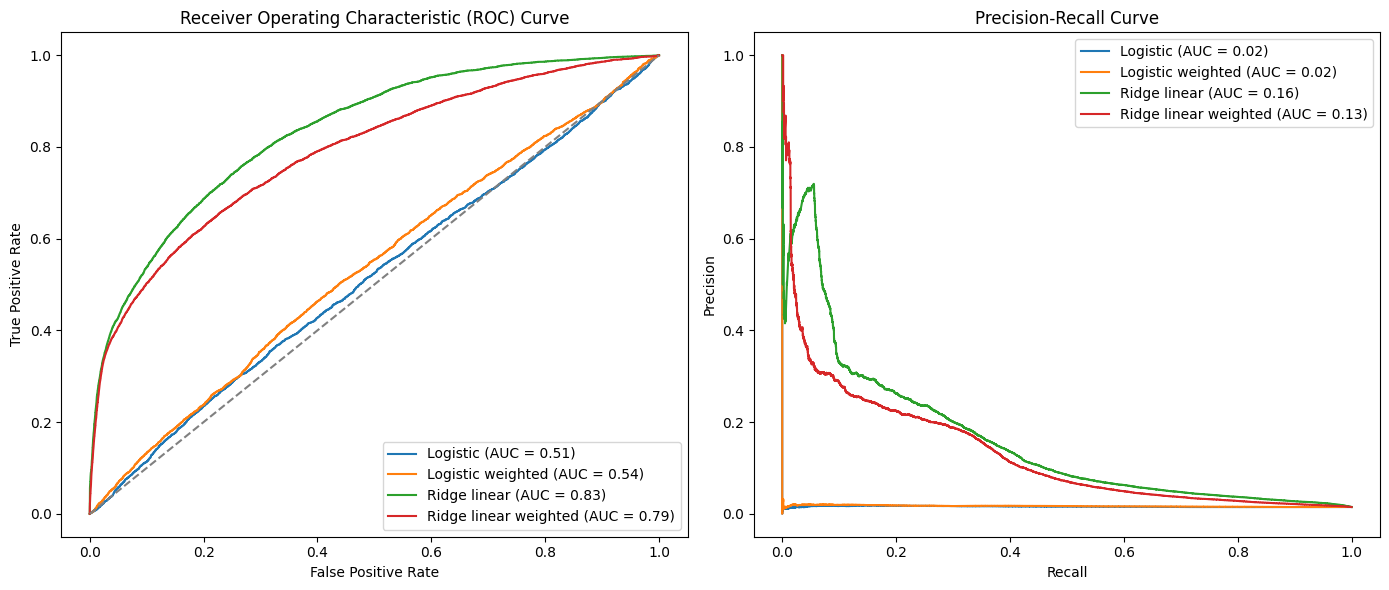

In [9]:
plot_roc_pr_curves([logistic_model, logistic_model_weighted, ridge_model, ridge_model_weighted], X_val, y_val, model_names=['Logistic', 'Logistic weighted', 'Ridge linear', 'Ridge linear weighted'])

We can see here that the Ridge Linear Classifier is the best performing model overall, but it will be important to take into account that its weighted version works better when high precissions (over ~0.7) are needed.

### **5- Business insights**
**It is important to define our assumptions and objectives in order to determine a threshold to make predictions.**

- We assume that our push notifications will follow the same current open rate in our app, around 5%.
- We assume that, if a positive prediction made by our model is correct, and the user opens the push notification, he will buy the product. This here, means that we can understand the `precision` of our model as the probability of bought, conditioned to the probability of the user opening his notification.

We consider the Probability of Success (PoS) as the global probability of bought for a push notification to a determined user, and the Number of Successes (NoS) as the expected number of sales achieved through the push notification system.

- $PoS = \frac{5}{100} \cdot precision$
- $NoS = \frac{5}{100} \cdot precision \cdot N$ , where N is the number of notifications sent.

As we want to achieve a 25% boost over the sales of a determined product, the precision needed (and therefore the threshold applied to our model) can be computed as follows:

$Precision = \frac{100}{4 \cdot 5} \cdot \frac{V}{N} = 5 \frac{V}{N}$ , where V is the total sales for that product over the last month (the number that will be increased by a 25%)

Example:

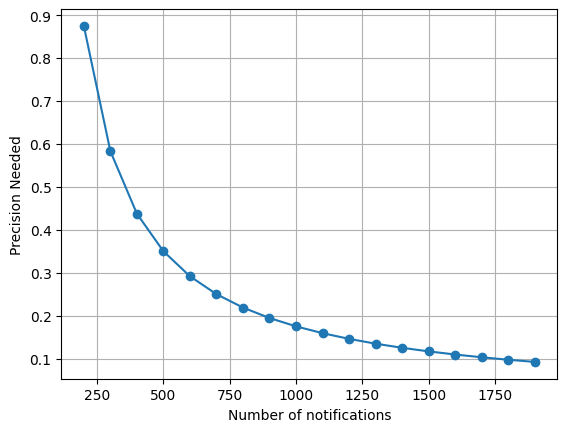

In [10]:
product = 33826472919172 # A given variant_id for the example
product2 = 34081589887108 # Oat milk (selected top product to avoid products sold once)

from src.module_3.metrics_fun import compute_last_month_sales
V = compute_last_month_sales(df, product2)

import matplotlib.pyplot as plt
import numpy as np

precision_needed = lambda N: 5*V/N
N_list = np.arange(200, 2000, 100)

plt.plot(N_list, precision_needed(N_list), marker='o', linestyle='-')
plt.xlabel("Number of notifications")
plt.ylabel("Precision Needed")
plt.grid(True)
plt.show()

Visualizing this curve is important because it gives us an idea of the number of 'uninterested users' that we will notify. For example: any point of this curve is expected to produce the same outcome (concerning sales) but we can achieve that outcome by notifying 175 users with a perfect precision or by notifying 1750 users with a precision of 0.1.

The limitation here is that we cannot simply choose the point with the highest possible precision. This is explained by the Precision-Recall curve: A high precision usually implies a low recall, which means that we are 'finding' a low percentage of the actual number of potential buyers (even though that we are very confident that the ones we found are going to buy; high precision). When that number of real potential buyers is not very high (as it is in this case) it might not be possible to achieve our goals by using a very high precision model: we will have to take higher risks and lower the precision (but always acknowledging the cost of sending ignored notifications).

After choosing the precision that we want to work with, we will need to find the threshold that will have to be used in our model in order to achieve the specified precision. 

### **6- Changing our data split: time wise splitting**

In [11]:
from src.module_3.metrics_fun import time_based_split

X_train, X_val, X_test, y_train, y_val, y_test = time_based_split(df, date_column='order_date', train_size=0.7, val_size=0.2, test_size=0.1)

### **7- Modeling for time-based split**
**First Model** (Logistic regression with L2 regularisation)

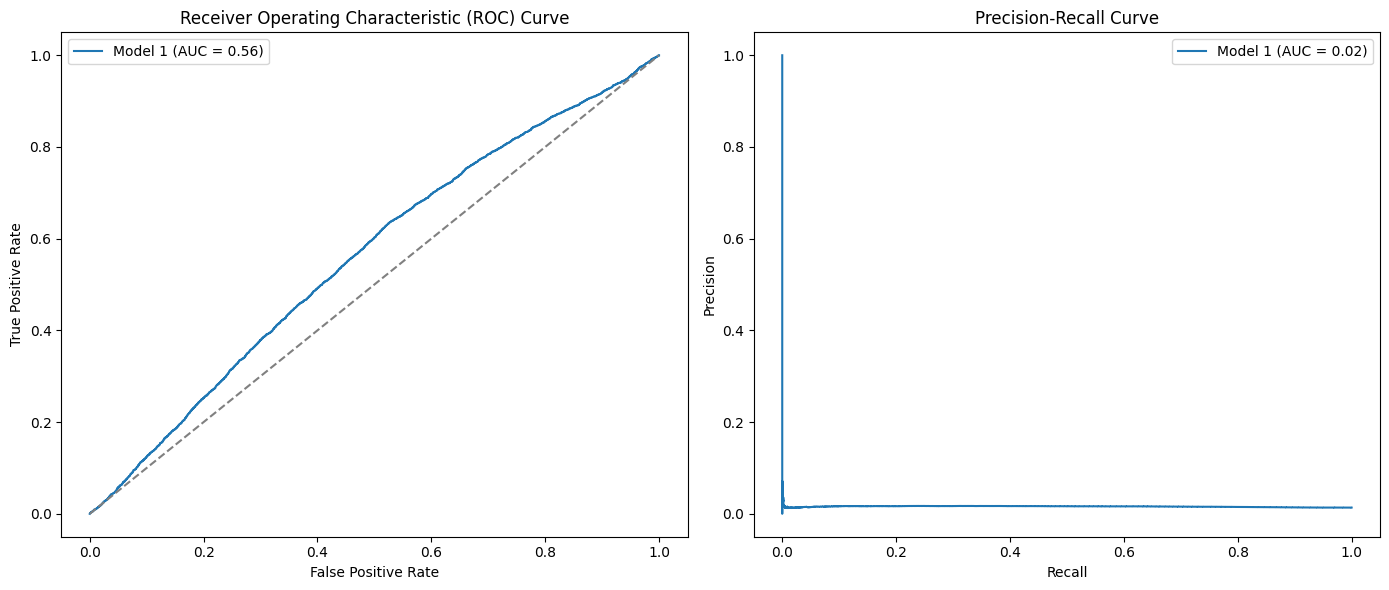

In [12]:
logistic_model_T = LogisticRegression(penalty='l2', max_iter=1000)
logistic_model_T.fit(X_train, y_train)

plot_roc_pr_curves(logistic_model_T, X_val, y_val)

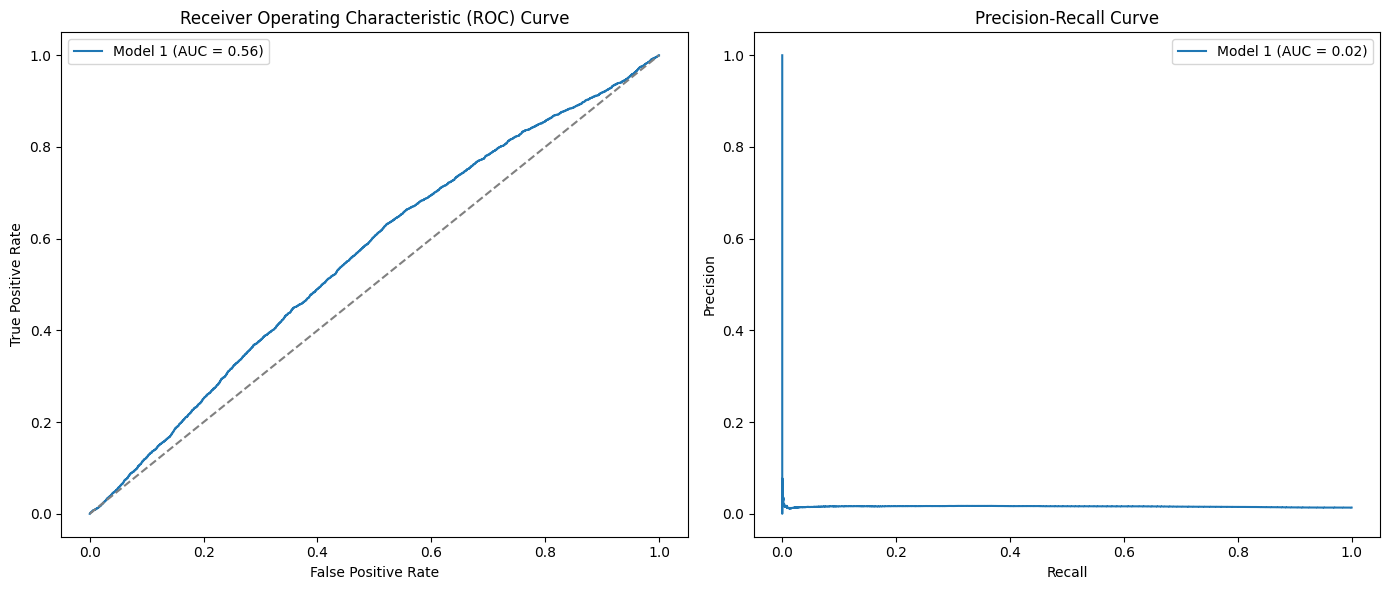

In [13]:
logistic_model_weighted_T = LogisticRegression(class_weight="balanced", max_iter=1000)
logistic_model_weighted_T.fit(X_train, y_train)

plot_roc_pr_curves(logistic_model_weighted_T, X_val, y_val)

**Second Model** (Ridge linear model)

/home/miguel/.cache/pypoetry/virtualenvs/zrive-ds-faYnIO2J-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.88932e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


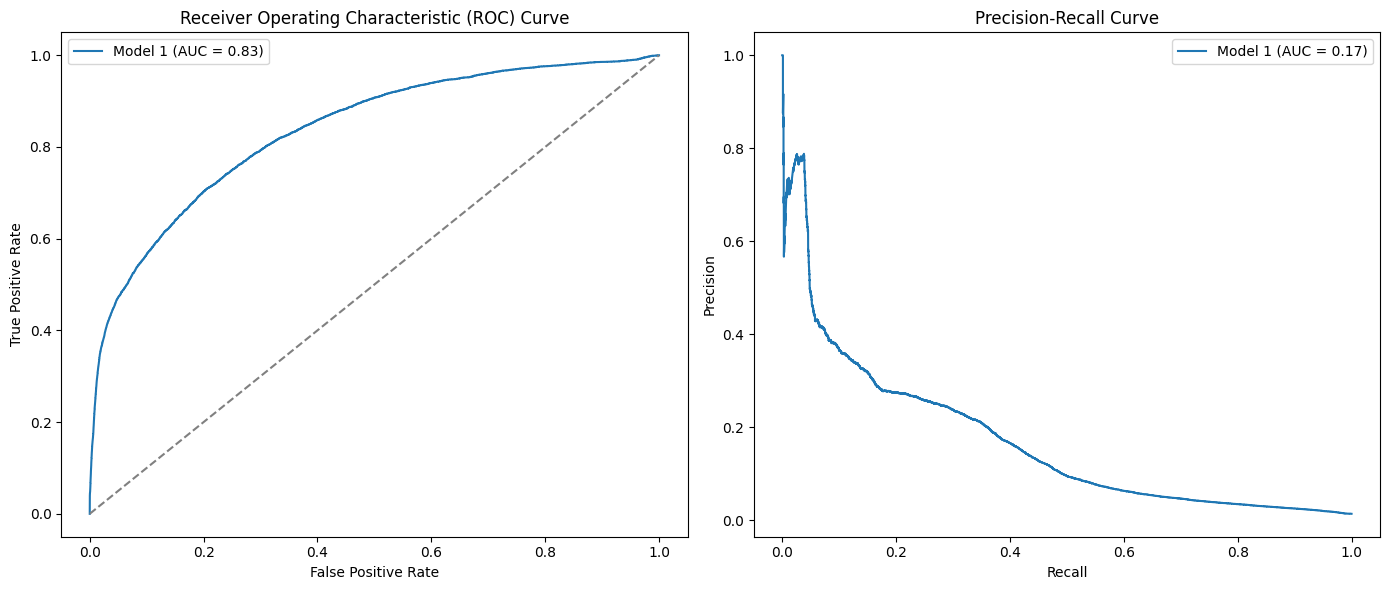

In [14]:
ridge_model_T = RidgeClassifier(alpha=1.0)
ridge_model_T.fit(X_train, y_train)

plot_roc_pr_curves(ridge_model_T, X_val, y_val)

/home/miguel/.cache/pypoetry/virtualenvs/zrive-ds-faYnIO2J-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.66336e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


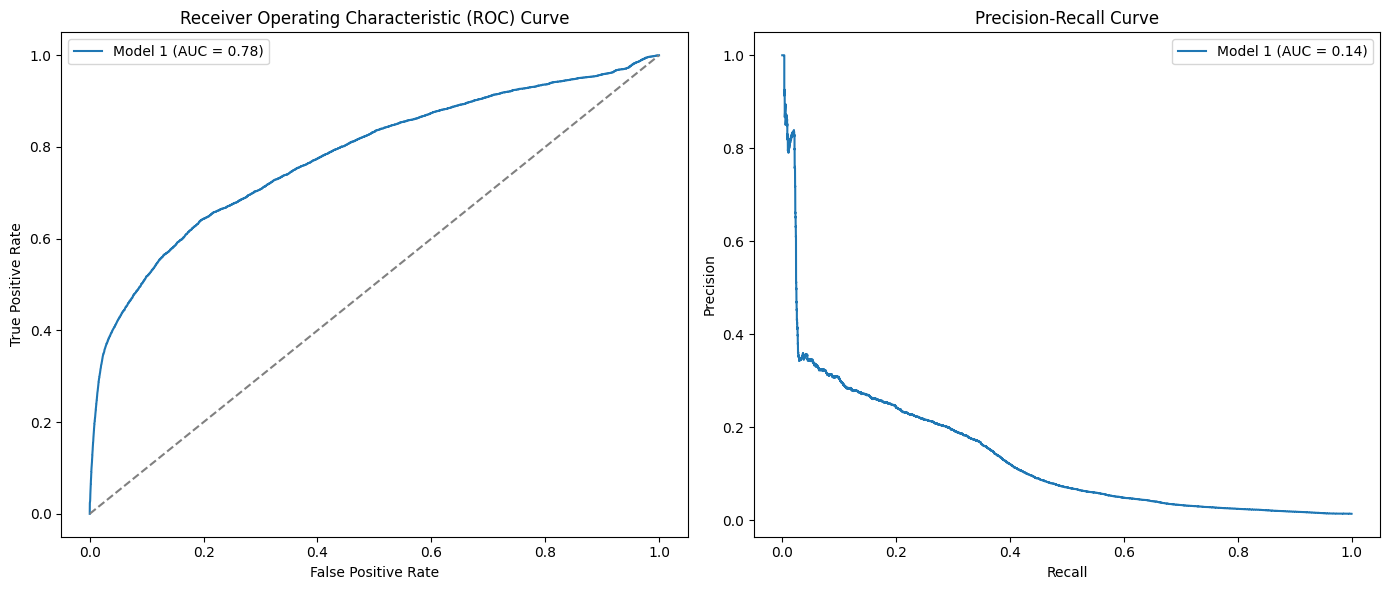

In [15]:
ridge_model_weighted_T = RidgeClassifier(class_weight="balanced", alpha=1.0)
ridge_model_weighted_T.fit(X_train, y_train)

plot_roc_pr_curves(ridge_model_weighted_T, X_val, y_val)

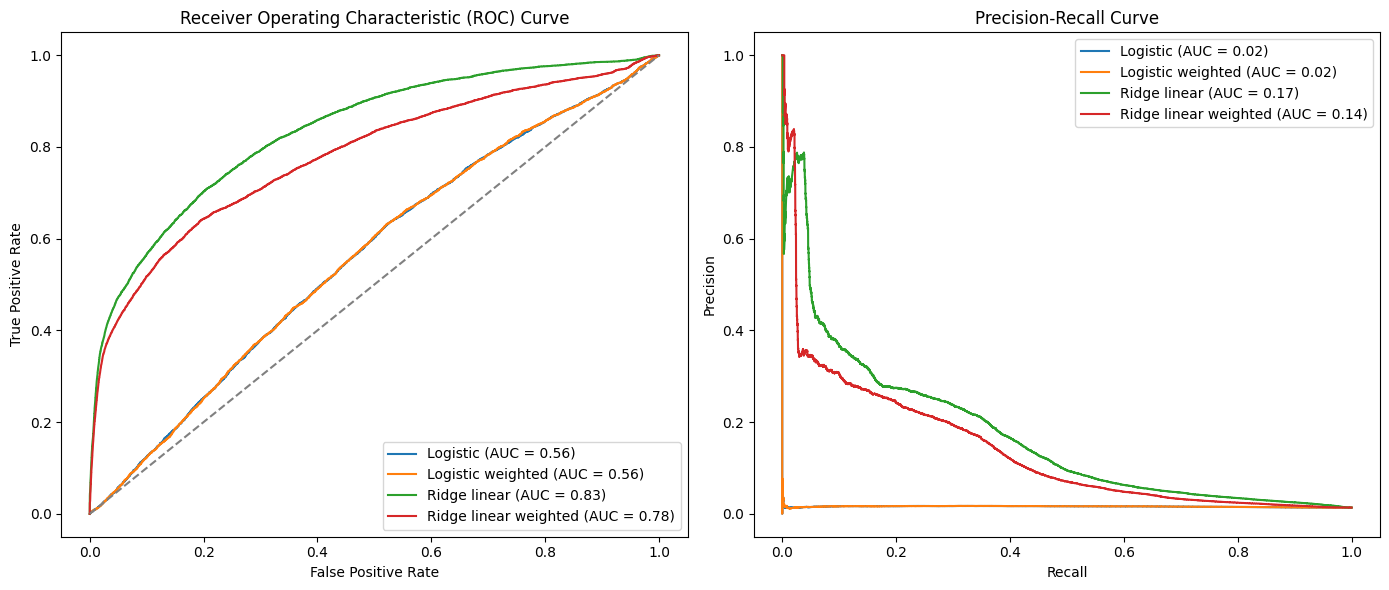

In [17]:
plot_roc_pr_curves([logistic_model_T, logistic_model_weighted_T, ridge_model_T, ridge_model_weighted_T], X_val, y_val, model_names=['Logistic', 'Logistic weighted', 'Ridge linear', 'Ridge linear weighted'])

1517


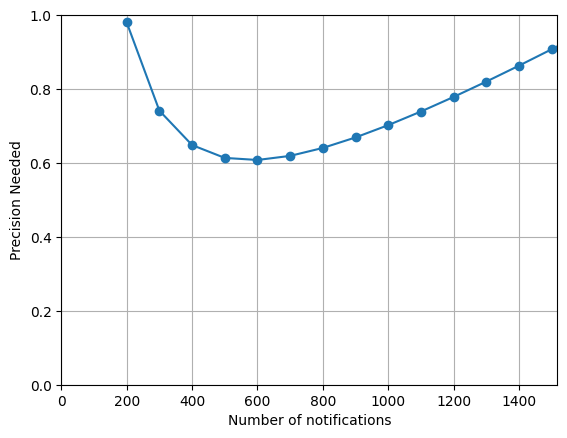

In [28]:
beta = 0.8
N_users = df['user_id'].nunique()
print(N_users)
optimize_precision = lambda N: 5*V/N + beta*(N/N_users)
N_list = np.arange(200, 2000, 100)

plt.plot(N_list, optimize_precision(N_list), marker='o', linestyle='-')
plt.xlabel("Number of notifications")
plt.ylabel("Precision Needed")
plt.xlim(0, N_users)
plt.ylim(0, 1)
plt.grid(True)
plt.show()